In [ ]:
! pip install pymystem3

In [ ]:
import os  # для работы с папками и файлами
import collections
import math
import numpy as np
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('russian')
from pymystem3 import Mystem
m = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


# Векторизация текстов. Начало

В итоге мы хотим уметь в числах записывать значение слов и значение отрывков текста.

Чтобы работать с текстами так, как и с другими объектами в ML (machine learning).

Постепенно до этого дойдём.

## One-hot encoding, BoW (bag of words)

Нам нужно представить слова и тексты в виде чисел, чтобы компьютер мог с ними работать. Нам хочется, чтобы эти представления текстов содержали в себе семантику, хотим понимать значения.

Простой способ: одно слово - одно число.

*мама - 1, мыла - 2, раму - 3*

Но хочется, чтоб при сложении слов из текста получалось значение текста, а не рандомное число.

Если записать эти числа так, чтоб везде, кроме слота с порядковым номером слова, были нули, получится

*мама - 001, мыла - 010, раму - 100*

Тогда предложение "мама мыла" будет 011.

А "мама мыла раму" будет 111.

Мы придумали векторы! У нас есть трёхмерное пространство, в котором у слова "мама" координаты вектора (0; 0; 1), а у текста "мама мыла раму" (1; 1; 1).

Можно руками написать векторизатор. Но он уже существует:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
corpus = [
	'мама мыла раму',
	'Мила мыла куклу и раму',
	'Римма мыла раму и мама мыла раму'
]

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)  # вот тут мы векторизовали тексты

In [ ]:
X # смотрим матрицу

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

Sparse matrix - разреженная матрица (матрица, в которой много нулей).

In [ ]:
X.toarray() # смотрим матрицу

array([[0, 1, 0, 1, 1, 0],
       [1, 0, 1, 1, 1, 0],
       [0, 1, 0, 2, 2, 1]])

In [ ]:
vectorizer.vocabulary_

{'мама': 1, 'мыла': 3, 'раму': 4, 'мила': 2, 'куклу': 0, 'римма': 5}

In [ ]:
# чтобы узнать индекс токена в словаре
vectorizer.vocabulary_.get('куклу')

0

In [ ]:
# чтобы узнать количественное вхождение каждого слова:
matrix_freq = np.asarray(X.sum(axis=0)).ravel()
final_matrix = np.array([np.array(vectorizer.get_feature_names_out()), matrix_freq])
final_matrix

array([['куклу', 'мама', 'мила', 'мыла', 'раму', 'римма'],
       [1, 2, 1, 4, 4, 1]], dtype=object)

In [ ]:
vectorizer.get_feature_names_out()  # так называются "фичи" наших текстов

array(['куклу', 'мама', 'мила', 'мыла', 'раму', 'римма'], dtype=object)

In [ ]:
df = pd.DataFrame(X.toarray())
df.columns =list(vectorizer.get_feature_names_out())
df

,куклу,мама,мила,мыла,раму,римма
0,0,1,0,1,1,0
1,1,0,1,1,1,0
2,0,1,0,2,2,1


Заметьте!
- Мы здесь верим, что текст - это просто набор слов!
- Не учитываем порядок слов.
- Векторы слов рандомные, семантики не содержат.

# TF-IDF - ещё один способ векторизации


### Отвлечёмся на вопрос: "Как сравнить несколько текстов?"

Как понять, какой текст о чём?  Как выделить ключевые слова?

Почему просто взять частотные - не самый лучший вариант?

А если убрать стопслова?

In [ ]:
! wget https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/38popugajev.txt
! wget https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/babushka.txt
! wget https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/zaryadka.txt
! wget https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/idti.txt
! wget https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/lechit.txt
! wget https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/letet.txt
! wget https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/zakon.txt

--2024-05-31 19:19:19--  https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/38popugajev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20456 (20K) [text/plain]
Saving to: ‘38popugajev.txt’

38popugajev.txt     100%[===================>]  19.98K  --.-KB/s    in 0.002s  

2024-05-31 19:19:19 (11.3 MB/s) - ‘38popugajev.txt’ saved [20456/20456]

--2024-05-31 19:19:19--  https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/data/oster/babushka.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 O

In [ ]:
file_list = os.listdir()  # список файлов и папок в директории, где запущена программа
file_list

['.config',
 'lechit.txt',
 '38popugajev.txt',
 'zaryadka.txt',
 'zakon.txt',
 'letet.txt',
 'idti.txt',
 'babushka.txt',
 'sample_data']

In [ ]:
txt_list = [filename for filename in file_list if filename.endswith('.txt')]
txt_list

['lechit.txt',
 '38popugajev.txt',
 'zaryadka.txt',
 'zakon.txt',
 'letet.txt',
 'idti.txt',
 'babushka.txt']

In [ ]:
name_text = {}
text_lex = {}
for filename in txt_list:
    with open(filename, encoding='UTF-8') as f:
        text = f.read()
    name_text[filename[:-4]] = text
    lemmas = m.lemmatize(text)
    words = [l for l in lemmas if l.isalpha()]
    text_lex[filename[:-4]] = words  # получили словарь {название текста: список лемм}

In [ ]:
list(text_lex.keys())

['lechit', 'idti', 'zakon', 'babushka', '38popugajev', 'letet', 'zaryadka']

In [ ]:
text_lex['38popugajev'][:20]

['удав',
 'склоняться',
 'над',
 'трава',
 'и',
 'рассматривать',
 'мартышка',
 'очень',
 'осторожно',
 'на',
 'цыпочки',
 'подходить',
 'к',
 'удав',
 'и',
 'тоже',
 'посмотреть',
 'в',
 'трава',
 'ползти']

- сравнить самые частотные слова

In [ ]:
for text in text_lex:
    print(text)
    fdist = collections.Counter(text_lex[text])
    print(fdist.most_common(15))

lechit
[('не', 71), ('и', 69), ('удав', 63), ('мартышка', 60), ('сказать', 52), ('ты', 50), ('я', 44), ('а', 39), ('слоненок', 38), ('попугай', 38), ('что', 36), ('он', 31), ('это', 31), ('в', 23), ('она', 21)]
idti
[('он', 47), ('не', 45), ('идти', 45), ('попугай', 42), ('и', 38), ('мартышка', 36), ('слоненок', 34), ('я', 29), ('что', 25), ('быть', 22), ('а', 20), ('сказать', 20), ('куда', 16), ('мы', 16), ('пойти', 14)]
zakon
[('удав', 31), ('он', 27), ('и', 24), ('мартышка', 23), ('не', 19), ('орех', 15), ('закон', 15), ('быть', 14), ('по', 14), ('попугай', 14), ('сказать', 12), ('а', 12), ('слоненок', 12), ('нет', 11), ('что', 10)]
babushka
[('и', 61), ('бабушка', 52), ('мартышка', 47), ('а', 40), ('слоненок', 37), ('удав', 34), ('сказать', 34), ('попугай', 30), ('на', 28), ('я', 27), ('она', 26), ('ты', 26), ('не', 26), ('что', 25), ('в', 24)]
38popugajev
[('удав', 84), ('и', 58), ('мартышка', 58), ('он', 49), ('попугай', 48), ('сказать', 40), ('а', 35), ('не', 35), ('я', 30), ('х

Ну вот, стопслова не убрали. Убираем.

In [ ]:
text_lex_nostopw = {}
for filename in text_lex:
    words_nostopw = []
    for word in text_lex[filename]:
        if word not in stopwords:
            words_nostopw.append(word)
    text_lex_nostopw[filename] = words_nostopw

In [ ]:
for text in text_lex_nostopw:
    print(text)
    fdist = collections.Counter(text_lex_nostopw[text])
    print(fdist.most_common(15))

lechit
[('удав', 63), ('мартышка', 60), ('сказать', 52), ('слоненок', 38), ('попугай', 38), ('это', 31), ('орех', 21), ('думать', 20), ('куча', 20), ('лежать', 19), ('спрашивать', 17), ('очень', 11), ('знать', 11), ('ходить', 11), ('весь', 10)]
idti
[('идти', 45), ('попугай', 42), ('мартышка', 36), ('слоненок', 34), ('сказать', 20), ('пойти', 14), ('почему', 11), ('удав', 11), ('гулять', 10), ('знать', 8), ('спрашивать', 7), ('закричать', 7), ('например', 7), ('колючий', 7), ('это', 6)]
zakon
[('удав', 31), ('мартышка', 23), ('орех', 15), ('закон', 15), ('попугай', 14), ('сказать', 12), ('слоненок', 12), ('хвост', 10), ('это', 8), ('самый', 8), ('упасть', 6), ('умный', 6), ('голова', 6), ('бросать', 5), ('спрашивать', 5)]
babushka
[('бабушка', 52), ('мартышка', 47), ('слоненок', 37), ('удав', 34), ('сказать', 34), ('попугай', 30), ('банан', 19), ('это', 14), ('очень', 13), ('ждать', 12), ('свой', 12), ('приезжать', 9), ('здравствовать', 8), ('сторона', 8), ('гулять', 8)]
38popugajev
[(

- а ещё можно биграммы и триграммы посмотреть (больше совпадений - тексты ближе)

In [ ]:
bigr_l = list(nltk.bigrams(text_lex_nostopw['38popugajev']))
bigr_counter = collections.Counter(bigr_l)
bigr_counter.most_common(10)

[(('сказать', 'попугай'), 11),
 (('сказать', 'мартышка'), 10),
 (('сказать', 'удав'), 8),
 (('свой', 'рост'), 8),
 (('спрашивать', 'мартышка'), 7),
 (('слоненок', 'мартышка'), 6),
 (('измерять', 'свой'), 5),
 (('твой', 'рост'), 5),
 (('удав', 'сказать'), 5),
 (('спрашивать', 'слоненок'), 5)]

In [ ]:
thgr_l = list(nltk.ngrams(text_lex_nostopw['38popugajev'], 3))
thgr_counter = collections.Counter(thgr_l)
thgr_counter.most_common(10)

[(('измерять', 'свой', 'рост'), 5),
 (('измерять', 'твой', 'рост'), 3),
 (('удав', 'сказать', 'попугай'), 3),
 (('ползти', 'ползти', 'спрашивать'), 2),
 (('ползти', 'спрашивать', 'мартышка'), 2),
 (('удав', 'ползти', 'ползти'), 2),
 (('сказать', 'мартышка', 'это'), 2),
 (('удав', 'принимать', 'решение'), 2),
 (('свой', 'рост', 'просто'), 2),
 (('сказать', 'мартышка', 'складываться'), 2)]

Во всех текстах одни и те же главные герои. Везде частотны слова 'попугай', 'слоненок', 'удав', 'мартышка'. Получается, тексты похожи.

Но нам важно понимать, чем они отличаются.

Интереснее смотреть на слова, которые в отдельных текстах частотные, а при этом в коллекции документов редкие.

**Есть метод!**

# TF-IDF

- TF — term frequency - частота слова внутри документа
- IDF — inverse document frequency - log(кол-во документов в корпусе/кол-во документов с этим словом)

**TF-IDF = TF * IDF**

Чем больше TF-IDF, тем важнее слово.

\#(логарифм натуральный, по основанию e≈2,72, но можно и другой)

IDF придумала Karen Spärck Jones (в 1972 году).

IDF можно считать немного по-другому. Например, добавляют единицу, чтоб избежать возможнонго деления на ноль: log(кол-во документов в корпусе**+1**/кол-во документов с этим словом**+1**)

In [ ]:
import pandas as pd

Давайте сначала на 3х коротких текстах

In [ ]:
documentA = 'мама мыла раму'
documentB = 'Мила мыла куклу и раму'
documentC = 'Римма мыла раму и мама мыла раму'

In [ ]:
bagOfWordsA = documentA.split(' ')
bagOfWordsB = documentB.split(' ')
bagOfWordsC = documentC.split(' ')

In [ ]:
uniqueWords = set(bagOfWordsA + bagOfWordsB + bagOfWordsC)

In [ ]:
# Вот все слова, которые встретились в текстах
uniqueWords

{'Мила', 'Римма', 'и', 'куклу', 'мама', 'мыла', 'раму'}

Делаем словарь {слово: кол-во употреблений} для каждого текста.


In [ ]:
numOfWordsA = dict.fromkeys(uniqueWords, 0)
for word in bagOfWordsA:
    numOfWordsA[word] += 1
numOfWordsB = dict.fromkeys(uniqueWords, 0)
for word in bagOfWordsB:
    numOfWordsB[word] += 1
numOfWordsC = dict.fromkeys(uniqueWords, 0)
for word in bagOfWordsC:
    numOfWordsC[word] += 1

In [ ]:
# В первом тексте столько раз встретилось каждое из слов
numOfWordsA

{'раму': 1, 'Римма': 0, 'Мила': 0, 'куклу': 0, 'и': 0, 'мама': 1, 'мыла': 1}

In [ ]:
pd.DataFrame([numOfWordsA, numOfWordsB, numOfWordsC])

,раму,Римма,Мила,куклу,и,мама,мыла
0,1,0,0,0,0,1,1
1,1,0,1,1,1,0,1
2,2,1,0,0,1,1,2


Считаем **TF** (частота слова внутри документа)

In [ ]:
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

In [ ]:
tfA = computeTF(numOfWordsA, bagOfWordsA)
tfB = computeTF(numOfWordsB, bagOfWordsB)
tfC = computeTF(numOfWordsC, bagOfWordsC)

In [ ]:
pd.DataFrame([tfA, tfB, tfC])

,Римма,куклу,мыла,раму,мама,и,Мила
0,0.000000,0.0,0.333333,0.333333,0.333333,0.000000,0.0
1,0.000000,0.2,0.200000,0.200000,0.000000,0.200000,0.2
2,0.142857,0.0,0.285714,0.285714,0.142857,0.142857,0.0


Считаем **IDF** (log(кол-во документов/кол-во документов с этим словом))

один раз для всех слов

In [ ]:
def computeIDF(documents):
    N = len(documents)

    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

In [ ]:
idfs = computeIDF([numOfWordsA, numOfWordsB, numOfWordsC])

In [ ]:
# Есть слова, которые встретились во многих текстах (значение меньше),
# есть "специфичные", которые встретились в малом кол-ве текстов (значение больше)
idfs

{'Римма': 1.0986122886681098,
 'куклу': 1.0986122886681098,
 'мыла': 0.0,
 'раму': 0.0,
 'мама': 0.4054651081081644,
 'и': 0.4054651081081644,
 'Мила': 1.0986122886681098}

In [ ]:
def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [ ]:
tfidfA = computeTFIDF(tfA, idfs)
tfidfB = computeTFIDF(tfB, idfs)
tfidfC = computeTFIDF(tfC, idfs)

In [ ]:
print('\n', documentA, '\n', documentB, '\n', documentC)
pd.DataFrame([tfidfA, tfidfB, tfidfC])


 мама мыла раму 
 Мила мыла куклу и раму 
 Римма мыла раму и мама мыла раму


,Римма,куклу,мыла,раму,мама,и,Мила
0,0.000000,0.000000,0.0,0.0,0.135155,0.000000,0.000000
1,0.000000,0.219722,0.0,0.0,0.000000,0.081093,0.219722
2,0.156945,0.000000,0.0,0.0,0.057924,0.057924,0.000000


Чем больше значение, тем важнее слово для текста.

"Рама" встречается во всех трёх - у неё значение везде ноль.

"Кукла" и "Мила" встречаются только во втором - они очень важны для второго текста (у них самые большие значения)

# TfidfVectorizer

Готовый инструмент из библиотеки [sklearn](https://scikit-learn.org/stable/)

In [ ]:
corpus = [documentA, documentB, documentC]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vect_tfidf = TfidfVectorizer()
mama_tfidf = vect_tfidf.fit_transform(corpus)

In [ ]:
mama_tfidf.toarray()

array([[0.        , 0.67325467, 0.        , 0.52284231, 0.52284231,
        0.        ],
       [0.6088451 , 0.        , 0.6088451 , 0.35959372, 0.35959372,
        0.        ],
       [0.        , 0.36384968, 0.        , 0.56512346, 0.56512346,
        0.4784186 ]])

In [ ]:
vect_tfidf.get_feature_names_out()

array(['куклу', 'мама', 'мила', 'мыла', 'раму', 'римма'], dtype=object)

In [ ]:
print('\n', documentA, '\n', documentB, '\n', documentC)

df = pd.DataFrame(mama_tfidf.toarray())
df.columns =list(vect_tfidf.get_feature_names_out())
df


 мама мыла раму 
 Мила мыла куклу и раму 
 Римма мыла раму и мама мыла раму


,куклу,мама,мила,мыла,раму,римма
0,0.000000,0.673255,0.000000,0.522842,0.522842,0.000000
1,0.608845,0.000000,0.608845,0.359594,0.359594,0.000000
2,0.000000,0.363850,0.000000,0.565123,0.565123,0.478419


Таблица получилось немного другой, потому что есть несколько способов посчитать idf. Но суть осталась прежней.

In [ ]:
# попытка приблизить нашу функцию к TfidfVectorizer
def computeIDF_2(documents):
    N = len(documents)
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log((N + 1) / (float(val) + 1)) + 1  # в этой строке
        # дополнительные единицы, которые призваны спасать от деления на ноль
    return idfDict

idfs = computeIDF_2([numOfWordsA, numOfWordsB, numOfWordsC])

tfidfA = computeTFIDF(tfA, idfs)
tfidfB = computeTFIDF(tfB, idfs)
tfidfC = computeTFIDF(tfC, idfs)

print('\n', documentA, '\n', documentB, '\n', documentC)
pd.DataFrame([tfidfA, tfidfB, tfidfC])


 мама мыла раму 
 Мила мыла куклу и раму 
 Римма мыла раму и мама мыла раму


,Римма,куклу,мыла,раму,мама,и,Мила
0,0.000000,0.000000,0.333333,0.333333,0.429227,0.000000,0.000000
1,0.000000,0.338629,0.200000,0.200000,0.000000,0.257536,0.338629
2,0.241878,0.000000,0.285714,0.285714,0.183955,0.183955,0.000000


#### Возможности sklearn векторизаторов

Теперь любой текст с этими словами можно векторизировать.

In [ ]:
vect_tfidf.transform(["Мила мыла раму и мама"]).toarray()

array([[0.        , 0.50410689, 0.66283998, 0.39148397, 0.39148397,
        0.        ]])

Векторайзеры в sklearn имеют три основных метода fit, transform и fit_transform.

`fit` - собирает словарь и статистики по текстам

`transform` - преобразует тексты в векторы, на основе уже собранного словаря

`fit_transform` - делает сразу и первое и второе (быстре чем 1 и 2 по очереди)


## А теперь для наших текстов то же самое


In [ ]:
bagOfWords_0 = text_lex['38popugajev']
bagOfWords_1 = text_lex['babushka']
bagOfWords_2 = text_lex['letet']
bagOfWords_3 = text_lex['zaryadka']
bagOfWords_4 = text_lex['zakon']
bagOfWords_5 = text_lex['znakomstvo']
bagOfWords_6 = text_lex['idti']
bagOfWords_7 = text_lex['lechit']
bagOfWords_8 = text_lex['perehod']
bagOfWords_9 = text_lex['son']

bagsOfWords = [bagOfWords_0, bagOfWords_1, bagOfWords_2, bagOfWords_3,
              bagOfWords_4, bagOfWords_5, bagOfWords_6, bagOfWords_7,
              bagOfWords_8, bagOfWords_9]

In [ ]:
oster_uniqueW = set(sum(bagsOfWords, []))

In [ ]:
numsOfWords = []
for bagOfWords in bagsOfWords:
    numOfWords = dict.fromkeys(oster_uniqueW, 0)
    for word in bagOfWords:
        numOfWords[word] += 1
    numsOfWords.append(numOfWords)

In [ ]:
idfs = computeIDF(numsOfWords)

In [ ]:
tfidfs = []
for i in range(len(numsOfWords)):
    tfidf = computeTFIDF(computeTF(numsOfWords[i], bagsOfWords[i]), idfs)
    tfidfs.append(tfidf)

df = pd.DataFrame(tfidfs)

In [ ]:
df

,может,держаться,навешивать,протирать,присниться,всплескивать,побежать,небо,необитаемый,укрепляться,...,терпеть,удовольствие,увидеть,мчаться,аааа,класть,хозяин,гулять,вертеться,бушевать
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001369,0.000716,0.000304,0.000000,0.000545,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000808,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000343,0.000000,0.000000,0.000000,0.000000,0.008641,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002377,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.002273,0.000905,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000807,0.000000,0.001543,...,0.000000,0.000000,0.000685,0.000000,0.000614,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.003406,0.000000,0.000000,0.000000,0.000000,0.000000,0.001703,0.003406,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.009406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.002174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000965,0.000000,0.000000,0.000000,0.000000,0.015198,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000866,0.000648,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000493,0.001239,0.000000,0.000000,0.002477,0.000000
8,0.000807,0.001079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001712,0.000000,0.000000,0.000000,0.003087,0.000000,0.000000,0.000000
9,0.001647,0.001101,0.000000,0.001575,0.004725,0.001101,0.000000,0.000000,0.004725,0.000000,...,0.000000,0.000824,0.000349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004725


In [ ]:
# Посмотрим на слова с наибольшим tf-idf в "38 попугаев"
collections.Counter(tfidfs[0]).most_common(15)

[('измерять', 0.02053434981861515),
 ('рост', 0.015747563433514026),
 ('ползти', 0.013396034942971109),
 ('принимать', 0.008611736749052855),
 ('половина', 0.008213739927446062),
 ('складываться', 0.006844783272871718),
 ('мерять', 0.006844783272871718),
 ('дергать', 0.005741157832701903),
 ('шагнуть', 0.005475826618297374),
 ('измеряться', 0.005475826618297374),
 ('порываться', 0.005475826618297374),
 ('э', 0.005475826618297374),
 ('глотать', 0.005475826618297374),
 ('целый', 0.004784298193918253),
 ('длинный', 0.004358100983943663)]

In [ ]:
# Бабушка
collections.Counter(tfidfs[1]).most_common(15)

[('бабушка', 0.05616830298427732),
 ('банан', 0.015352673343753547),
 ('ждать', 0.012961916073294768),
 ('здравствовать', 0.012362872982518366),
 ('присмотр', 0.009272154736888777),
 ('гулять', 0.008641277382196512),
 ('взрослый', 0.007726795614073979),
 ('внук', 0.007726795614073979),
 ('спелый', 0.007726795614073979),
 ('дорогой', 0.007726795614073979),
 ('воспитание', 0.007726795614073979),
 ('приезжать', 0.007272318952304312),
 ('товарищ', 0.006181436491259183),
 ('обращаться', 0.0046360773684443884),
 ('хвостливый', 0.0046360773684443884)]

In [ ]:
# Зарядка
collections.Counter(tfidfs[3]).most_common(15)

[('зарядка', 0.047841915471055915),
 ('упражнение', 0.016976163554245645),
 ('нога', 0.015353396981805548),
 ('падать', 0.012282717585444438),
 ('для', 0.010490379662357352),
 ('вместе', 0.00975609302396706),
 ('мускул', 0.00925972557504308),
 ('спина', 0.00862969390045094),
 ('забывать', 0.007716437979202567),
 ('начинаться', 0.006472270425338205),
 ('хватать', 0.0061731503833620536),
 ('нравиться', 0.0061731503833620536),
 ('лежа', 0.0061731503833620536),
 ('ставить', 0.0056486659720385735),
 ('утро', 0.005393558687781837)]

In [ ]:
# Закон тяготения
collections.Counter(tfidfs[4]).most_common(15)

[('закон', 0.03414649036281684),
 ('орех', 0.0194403974230726),
 ('бросать', 0.01628419443418703),
 ('закрываться', 0.01628419443418703),
 ('стукнуть', 0.013027355547349623),
 ('жалко', 0.009105730763417823),
 ('умный', 0.007776158969229039),
 ('природа', 0.006811727322919016),
 ('наоборот', 0.006811727322919016),
 ('трахнуть', 0.0065136777736748116),
 ('действовать', 0.0065136777736748116),
 ('делаться', 0.0065136777736748116),
 ('макушка', 0.0065136777736748116),
 ('затылок', 0.0065136777736748116),
 ('банановый', 0.0065136777736748116)]

То же самое с помощью TfidfVectorizer

In [ ]:
oster_corpus = list(name_text.values())  # список списков слов

In [ ]:
vect_tfidf = TfidfVectorizer()
oster_tfidf = vect_tfidf.fit_transform(oster_corpus)

In [ ]:
df = pd.DataFrame(oster_tfidf.toarray())
df.columns =list(vect_tfidf.get_feature_names_out())
df

,ааа,аааа,ага,ай,аккуратно,ананасы,африке,африку,ах,ахнул,...,этом,этому,этот,эту,эх,яблоко,ясно,ящиков,ящичек,ёй
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031585,0.00000,0.045216,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010338,0.00000,0.000000,0.01741,...,0.000000,0.000000,0.015457,0.018692,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.010851,0.009745,0.000000,0.000000,0.000000,0.000000,0.01641,0.000000,0.00000,...,0.010851,0.000000,0.021854,0.000000,0.000000,0.000000,0.036615,0.000000,0.000000,0.01641
3,0.013933,0.009213,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.009213,0.000000,0.012370,0.007479,0.000000,0.000000,0.000000,0.013933,0.013933,0.00000
4,0.000000,0.000000,0.010782,0.015436,0.000000,0.018158,0.010782,0.00000,0.000000,0.00000,...,0.024013,0.000000,0.008060,0.000000,0.018158,0.000000,0.000000,0.000000,0.000000,0.00000
5,0.000000,0.016161,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.041554,0.00000,...,0.000000,0.000000,0.000000,0.013121,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
6,0.000000,0.000000,0.011969,0.000000,0.000000,0.000000,0.011969,0.00000,0.000000,0.00000,...,0.000000,0.020155,0.008947,0.000000,0.000000,0.000000,0.014990,0.000000,0.000000,0.00000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.007933,0.028780,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
8,0.000000,0.000000,0.037433,0.053588,0.031519,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.055966,0.016920,0.000000,0.031519,0.000000,0.000000,0.000000,0.00000
9,0.000000,0.011430,0.020529,0.000000,0.000000,0.000000,0.010265,0.00000,0.000000,0.00000,...,0.011430,0.000000,0.023020,0.018559,0.000000,0.000000,0.025712,0.000000,0.000000,0.00000


In [ ]:
uniq_words = list(vect_tfidf.get_feature_names_out())

In [ ]:
# Посмотрим на слова с наибольшим tf-idf рассказе "38 попугаев"
word_tfidf = dict(zip(uniq_words,
                      list(vect_tfidf.transform([name_text['38popugajev']]).toarray()[0])))
collections.Counter(word_tfidf).most_common(15)

[('удав', 0.3701033412448211),
 ('мартышка', 0.30943066235222744),
 ('рост', 0.244098432348634),
 ('не', 0.21235437612407768),
 ('попугай', 0.18201803667778085),
 ('он', 0.17942958763305333),
 ('сказал', 0.16381623301000278),
 ('что', 0.1577489651207434),
 ('голова', 0.14106364888002004),
 ('хвост', 0.13955634593681926),
 ('слонёнок', 0.13347989356370596),
 ('его', 0.1329108056541136),
 ('измерить', 0.11487301874001601),
 ('порвался', 0.11487301874001601),
 ('хи', 0.11487301874001601)]

In [ ]:
# Бабушка
word_tfidf = dict(zip(uniq_words,
                      list(vect_tfidf.transform([name_text['babushka']]).toarray()[0])))
collections.Counter(word_tfidf).most_common(15)

[('бабушка', 0.5179896983102189),
 ('банан', 0.2959623026029398),
 ('мартышка', 0.21884648219347042),
 ('на', 0.18022651474756388),
 ('что', 0.17378985350657944),
 ('не', 0.16735319226559503),
 ('она', 0.1442694804950735),
 ('попугай', 0.1416065473016573),
 ('слонёнок', 0.1416065473016573),
 ('бабушке', 0.12186683048356345),
 ('сказала', 0.11585990233771963),
 ('здравствуйте', 0.1044572832716258),
 ('играть', 0.10359793966204377),
 ('удав', 0.10298657985575078),
 ('ты', 0.0987019681368305)]

In [ ]:
# Зарядка
word_tfidf = dict(zip(uniq_words,
                      list(vect_tfidf.transform([name_text['zaryadka']]).toarray()[0])))
collections.Counter(word_tfidf).most_common(15)

[('зарядку', 0.31114529957944087),
 ('мартышка', 0.28759175435995943),
 ('ноги', 0.27919648258543256),
 ('вместе', 0.2155586596282608),
 ('на', 0.19172783623997297),
 ('попугай', 0.1853369083653072),
 ('удав', 0.1853369083653072),
 ('для', 0.16712795240893782),
 ('не', 0.1661641247413099),
 ('слонёнок', 0.1661641247413099),
 ('зарядка', 0.15557264978972044),
 ('делать', 0.1437057730855072),
 ('он', 0.11200077375226612),
 ('каждое', 0.10371509985981361),
 ('мускулы', 0.10371509985981361)]

### Тренировка векторизуйте тексты Остера c помощью CountVectorizer.

# Word2Vec

Мы видели 2 способа векторизации текстов. BoW и tf-idf.

Это просто, но в них семантика слов не учитывается.

По-русски понятные объяснения и картинки смотрите [тут](https://habr.com/ru/post/446530/)


2 важные мысли:
1. **Мы можем представить себе что угодно как совокупность признаков.**
- король - муж.: 1, богатый: 1, властный: 1
- королева - муж.: 0, богатый: 1, властный: 1
- нищий - муж.: 1, богатый: 0, властный: 0
- графиня - муж.: 0, богатый: 0.75, властный: 0.75

Если мы захотим различать больше слов, добавится ещё признаков. Например, машина - одушевлённость:0 (а у людей будет 1), транспорт:1 (а у яблока будет 0) и т.д.

(В итоге король - [1 1 1], королева [0 1 1], графиня [0 0.75 0.75]. Сейчас мы сами решили, какая ось нашего многомерного пространства за что отвечает, но оптимально все признаки не расписать, дальше у нас будут абстрактные оси.)

2. **Легко посчитать, насколько близки векторы.**

Для этого нужна косинусная близость.

![img](https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/pic/cos%20dist.png)

Найдём косинусную близость между a(4;1) и b(3;5).
$$\frac{a_1*b_1+a_2*b_2}{\sqrt{a_1^2+a_2^2}*\sqrt{b_1^2+b_2^2}}=\frac{4*3+1*5}{\sqrt{4^2+1^2}*\sqrt{3^2+5^2}}=0.7071$$

In [ ]:
import math

(4*3+1*5)/(math.sqrt(4**2+1**2)*math.sqrt(3**2+5**2))

0.7071067811865475

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([[4, 1]], [[3, 5]])

array([[0.70710678]])

In [ ]:
print(cosine_similarity([[4, 1]], [[4, 1]]))    # самый близкий - 1
print(cosine_similarity([[4, 1]], [[-1, 4]]))   # перпендикулярный - 0
print(cosine_similarity([[4, 1]], [[-4, -1]]))  # противоположный - -1

<img src="https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/pic/vectors.png" width="350" height="300">

Посмотрим на модель word2vec на сайте [Rusvectores](https://rusvectores.org/ru/calculator/).

#### Как это работает?

Word2vec принимает большой текстовый корпус в качестве входных данных и сопоставляет каждому слову вектор, выдавая координаты слов на выходе. Сначала он создает словарь, «обучаясь» на входных текстовых данных, а затем вычисляет векторное представление слов. Векторное представление основывается на контекстной близости: слова, встречающиеся в тексте рядом с одинаковыми словами (а следовательно, согласно дистрибутивной гипотезе, имеющие схожий смысл), в векторном представлении будут иметь близкие координаты векторов-слов. Для вычисления близости слов используется косинусное близость между их векторами.


С помощью дистрибутивных векторных моделей можно строить семантические пропорции (они же аналогии) и решать примеры:

+ король: мужчина = королева: женщина $\Rightarrow$
+ король - мужчина + женщина = королева

![w2v](https://raw.githubusercontent.com/tbkazakova/compling_for_lyceum/main/pic/word2vec.png)

#### Работа с моделью

Модели word2vec бывают разных форматов:

+ .vec.gz — обычный файл
+ .bin.gz — бинарник

Загружаются они с помощью одного и того же класса `KeyedVectors`, меняется только параметр `binary` у функции `load_word2vec_format`.

Если же эмбеддинги обучены не с помощью word2vec, то для загрузки нужно использовать функцию `load`. Т.е. для загрузки предобученных эмбеддингов `glove`, `fasttext`, `bpe` и любых других нужна именно она.

Скачаем с RusVectōrēs модель для русского языка, обученную на НКРЯ и Википедии образца 2018 г.

In [ ]:
import re
import gensim
import logging
import nltk.data
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import word2vec

import warnings
warnings.filterwarnings('ignore')

In [ ]:
urllib.request.urlretrieve("https://rusvectores.org/static/models/rusvectores4/unigrams/ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz", "ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz")

('ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz',
 <http.client.HTTPMessage at 0x79c861b69c00>)

In [ ]:
m = 'ruwikiruscorpora-nobigrams_upos_skipgram_300_5_2018.vec.gz'

if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)

In [ ]:
words = ['хороший_ADJ', 'плохой_ADJ', 'ужасный_ADJ', 'жуткий_ADJ', 'страшный_ADJ', 'красный_ADJ', 'синий_ADJ']

Просим у модели самые близкие слова к данным словам

In [ ]:
for word in ['хороший_ADJ', 'страшный_ADJ', 'красный_ADJ']:
    # есть ли слово в модели?
    if word in model:
        print(word)
        # смотрим на вектор слова (его размерность 300, смотрим на первые 10 чисел)
        print(model[word][:10])
        # выдаем 10 ближайших соседей слова:
        for i in model.most_similar(positive=[word], topn=10):
            # слово + коэффициент косинусной близости
            print(i[0], i[1])
        print('\n')
    else:
        # Увы!
        print('Увы, слова "%s" нет в модели!' % word)

хороший_ADJ
[ 0.05271   0.084645  0.011362 -0.021384  0.005557  0.106148  0.038565
 -0.047672 -0.002414  0.088515]
плохой_ADJ 0.8079851269721985
неплохой_ADJ 0.7780063152313232
хороший_ADV 0.7469695806503296
хорошо_ADJ 0.7432217001914978
превосходный_ADJ 0.7101497650146484
отличный_ADJ 0.7055953741073608
плохой_VERB 0.6580293774604797
хорошее_ADJ 0.6565685272216797
недурной_ADJ 0.6560452580451965
плохой_ADV 0.6524969935417175


страшный_ADJ
[ 0.00463  -0.121499 -0.00197   0.012488 -0.003129  0.033653 -0.149805
  0.03068  -0.029428  0.045449]
ужасный_ADJ 0.8260010480880737
жуткий_ADJ 0.8085675239562988
ужасать_VERB 0.7013491988182068
чудовищный_ADJ 0.7007293105125427
страшно_ADJ 0.6778762340545654
мучительный_NOUN 0.6615219712257385
страшнотраница_NOUN 0.6602171659469604
страшный_ADV 0.6600751280784607
причудиться_VERB 0.6573998332023621
престрашный_ADJ 0.6484856605529785


красный_ADJ
[-0.00301  -0.13654  -0.053827 -0.035158 -0.055694  0.027937 -0.04009
  0.01502   0.026079 -0.011396]


Нашли косинусную близость слов:

In [ ]:
print(model.similarity('плохой_ADJ', 'хороший_ADJ'))

0.80798507


### Как нам векторизовать текст?

Сложить векторы слов из него.

In [ ]:
# вот первые 10 лемм нашего текста
text_lex['38popugajev'][:10]

['удав',
 'склоняться',
 'над',
 'трава',
 'и',
 'рассматривать',
 'мартышка',
 'очень',
 'осторожно',
 'на']

В этой модели слова хранятся сразу с частеречными тегами. То есть нам нужно их добавить (в модели нет слова 'удав', только 'удав_NOUN').

Теги в модели такие же, как на сайте UD (https://universaldependencies.org/u/pos/all.html). То есть такие же, как в spacy и stanza.

In [ ]:
import spacy

In [ ]:
! python3 -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 818.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 31.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nlp = spacy.load("ru_core_news_sm")

In [ ]:
texts_words_possed_texts = {}
for filename in txt_list:
    with open(filename, encoding='UTF-8') as f:
        text = f.read()
    doc = nlp(text)
    words_possed = []
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT']:
            words_possed.append(token.lemma_+'_'+token.pos_)
    texts_words_possed_texts[filename] = words_possed

In [ ]:
texts_words_possed_texts['38popugajev.txt'][:15]

['удав_PROPN',
 'склониться_VERB',
 'над_ADP',
 'трава_NOUN',
 'и_CCONJ',
 'что_PRON',
 '-_PRON',
 'то_PRON',
 'рассматривать_VERB',
 'мартышка_NOUN',
 'очень_ADV',
 'осторожно_ADV',
 'на_ADP',
 'цыпочка_NOUN',
 'подойти_VERB']

In [ ]:
text_vector = {}
for text in texts_words_possed_texts:
    vector = 0
    for word in texts_words_possed_texts[text]:
        if word in model:
            vector += model[word]
    text_vector[text] = vector

Сейчас в переменной text_vector лежит словарь: {название текста: его вектор}

Нарисуем на плоскости тексты, расположенные в многомерном пространстве (воспользуемся одним из методов уменьшения размерности - PCA - principal component analysis)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

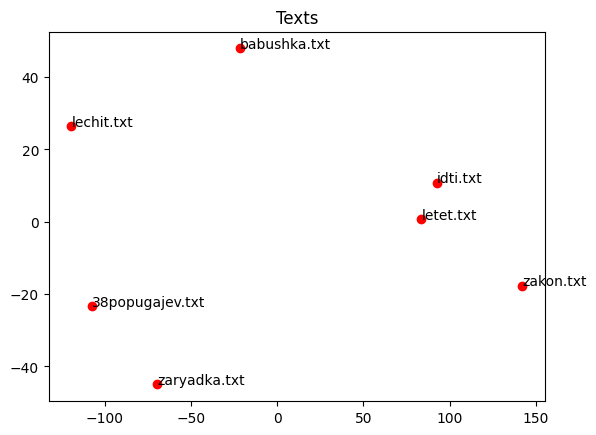

In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(list(text_vector.values()))

plt.scatter(coords[:, 0], coords[:, 1], color='red')
plt.title('Texts')

for i, text in enumerate(text_vector):
    plt.annotate(text, xy=(coords[i, 0], coords[i, 1]))
plt.show()